In [17]:
import quantecon as qe
import numpy as np 
from numba import jit , njit, prange, vectorize, jitclass, prange, float64, int32
from interpolation import mlinterp, interp
import matplotlib.pyplot as plt

from matplotlib import cm
import scipy.optimize as op

from scipy.stats import cumfreq, beta
from scipy.interpolate import interp1d
from quantecon.optimize.scalar_maximization import brent_max
from scipy.optimize import minimize_scalar

%matplotlib inline

In [2]:
#This block will compute the actual realizations of states
#& updating of the beliefs by the agent 
# overall idea is on each iteration - change the distribution from wich the shocks are drawn - (Beta distribution) 
np.random.seed(1234)
n = 100 # Number of periods  
P = [[0.4,0.6],
    [0.2, 0.8]]
mc = qe.MarkovChain(P,state_values = ('h','l'))
X = mc.simulate(ts_length = n) # realization of real shock


# initial values
u01= 10
u00= 10
u11= 10
u10= 10      

#Count the occurences of h and l at each time period
iks = ''.join(X)

#iks.count('hh', sub[ , 0,[,7]])
def frequencyCount(mainStr, subStr):
   counter = pos = 0
   while(True):
       pos = mainStr.find(subStr , pos)
       if pos > -1:
           counter = counter + 1
           pos = pos + 1
       else:
           break
   return counter

# mij- are the added numbers of occurrences each period  
m00 = np.empty(n, dtype = int)
m01 = np.empty(n, dtype = int)
m10 = np.empty(n, dtype = int)
m11 = np.empty(n, dtype = int)


def  createMvectors(m, subStr):
    for i in range(n):
        m[i] = frequencyCount(iks[0:i],subStr)
    return m
    
    
createMvectors(m00,'ll')
createMvectors(m01,'lh')
createMvectors(m11,'hh')
createMvectors(m10,'hl')    


#add the prior
# so that get the poserior values of beta distribution 
nu00 = m00 + u00
nu01 = m01 + u01
nu11 = m11 + u11
nu10 = m10 + u10

In [50]:
opt_growth_data = [
    ('α', float64), # Production parameter
    ('b', float64), # Discount factor
    #('ϕ', float64),  # proportional cost of BU
    #('cost', float64),  #  cost of BU       
    ('nuii', float64), #parameter of posterior 1
    ('nuij', float64), #parameter of posterior 2
    ('p', float64), # RE probability
    ('grid', float64[:]), # Grid (array)
    ('shocks', float64[:]) # Shock draws (array)
]

In [5]:
i= 1
n=50

In [6]:
@jitclass(opt_growth_data)
class OptimalGrowthModel:
    def __init__ (self,
                  nuii  , # nu are values for beta function posterior 
                  nuij, 
                  α = 0.4, #parameter of production function k^α
                  b = 0.96,
                  grid_max=n/2,
                  grid_size=n,
                  shock_size=n,  # by shock I mean the draw from the distribution of the probabbilities (Beta) 
                  seed=1234):   # that will be actually chosen by the agent as the posterior to act upon 
        
            self.α, self.b, self.nuii, self.nuij = α, b, nuii, nuij
                # Set up grid
            self.grid = np.linspace(1e-5, grid_max, grid_size)
                # Store shocks (with a seed, so results are reproducible)
            np.random.seed(seed)
            self.shocks =   (np.random.beta(nuii,nuij,shock_size))*((np.exp(1)-1)+1)
            #np.exp(1)*p +(1-p)np.exp(0)=p(np.exp(1)-1)+1 
            
    def f(self,k):
        return k**self.α
            
    def u(self, c):
        return np.log(c)
            
    def objective(self, c, y, v_array):
        """
         Right hand side of the Bellman equation.
        """
        u, f, b, shocks = self.u, self.f, self.b, self.shocks
        v = lambda x: interp(self.grid, v_array, x)
        return u(c) + b * np.mean(v(f(y - c) * shocks))
        
        
            

In [7]:
@jit(nopython=True)  # one iteration in estimation of the value function
def T(og, v):
    """
    The Bellman operator.
    * og is an instance of OptimalGrowthModel
    * v is an array representing a guess of the value function
    """
    v_new = np.empty_like(v)
    
    for i in range(len(og.grid)):
        y = og.grid[i]
        # Maximize RHS of Bellman equation at state y
        v_max = brent_max(og.objective, 1e-10, y, args=(y, v))[1]
        v_new[i] = v_max
    
    return v_new


In [8]:
@jit(nopython=True)
def get_greedy(og, v):
    """
    Compute a v-greedy policy.
    * og is an instance of OptimalGrowthModel
    * v is an array representing a guess of the value function
    """
    v_greedy = np.empty_like(v)
    for i in range(len(og.grid)):
        y = og.grid[i]
    # Find maximizer of RHS of Bellman equation at state y
        c_star = brent_max(og.objective, 1e-10, y, args=(y, v))[0]
        v_greedy[i] = c_star
    return v_greedy

In [32]:
def solve_model(og,
                tol=1e-4,
                max_iter=1000,
                verbose=True,
                print_skip=25):
    # Set up loop
    v = np.log(og.grid) # Initial condition
    i = 0
    error = tol + 1
    while i < max_iter and error > tol:
        v_new = T(og, v)
        error = np.max(np.abs(v - v_new))
        i += 1
        if verbose and i % print_skip == 0:
            print(f"Error at iteration {i} is {error}.")
        v = v_new
    
    if i == max_iter:
        print("Failed to converge!")
    
    if verbose and i < max_iter:
        print(f"\nConverged in {i} iterations.")
    return v_new

In [10]:
# Simulate consumption & output for the no updating case
def simulate_og0(σ_func, og, y0=0.1, ts_length=50):
    '''
    Compute a time series given consumption policy σ.
    '''
    c = np.empty(ts_length)
    y = np.empty(ts_length)
    ξ = ( X == 'h')
    y[0] = y0
    for t in range(ts_length-1):
        y[t+1] = (y[t] - σ_func(y[t]))**og.α * np.exp(ξ[t])
        c[t] = σ_func(y[t])
    return y, c

In [ ]:
# Below code: just check the functions to be working
p00= 0.4
p01 = 0.6 
og00 = OptimalGrowthModel(nuii = p00, nuij =p01)
v_solution = solvemodel(og)
v_greedy = get_greedy(og, v_solution)
fig, ax = plt.subplots()
ax.plot(og.grid, v_greedy, lw=2,
alpha=0.6, label='Approximate value function')
ax.legend(loc='lower right')
plt.show()


σ_func = lambda x: interp(og.grid, v_greedy, x)
y_0, c_0 = simulate_og0(σ_func, og, y0=0.1, ts_length=50)

fig, ax = plt.subplots()
ax.plot(y_0, lw=2, alpha=0.6,
label='y no upd')
ax.plot(c_0 , lw=2, alpha=0.6,
label='c no upd ')
ax.legend()
ax.set_xlim(0, 45)

Case 1: Updating agent. With the prior:  u00, u01, u11, u10 = 10, 10, 10, 10
    

In [78]:

def simulate_upd_y_c(y0, ts_length, Verbose):
    '''
    Compute a time series given consumption policy σ.
    '''
    c = np.empty(ts_length)
    y = np.empty(ts_length)
    ξ = ( X == 'h')
    y[0] = y0
    for t in range(ts_length-1):
        if ξ[t] == 0 :
            og = OptimalGrowthModel(nuii = nu00[t+1],nuij = nu01[t+1])
            v_solution = solve_model(og,verbose= Verbose)
            v_greedy = get_greedy(og, v_solution)
            σ_func = lambda x: interp(og.grid, v_greedy, x)
            y[t+1] = (y[t] - σ_func(y[t]))**og.α * np.exp(ξ[t])
            c[t] = σ_func(y[t])
        else:
            og = OptimalGrowthModel(nuii = nu11[t+1],nuij = nu10[t+1])
            v_solution = solve_model(og,verbose= Verbose)
            v_greedy = get_greedy(og, v_solution)
            σ_func = lambda x: interp(og.grid, v_greedy, x)
            y[t+1] = (y[t] - σ_func(y[t]))**og.α * np.exp(ξ[t])
            c[t] = σ_func(y[t])
       
    return y, c

In [79]:
y_upd, c_upd = simulate_upd_y_c(0.01, 50, False)

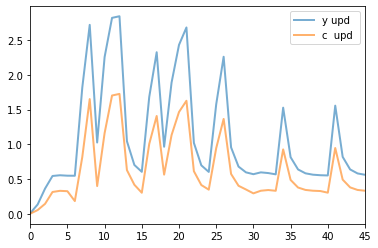

In [41]:
fig, ax = plt.subplots()
ax.plot(y_upd, lw=2, alpha=0.6,
label='y upd')
ax.plot(c_upd , lw=2, alpha=0.6,
label='c  upd ')
ax.legend()
ax.set_xlim(0, 45)
plt.savefig('C_Y_upd.pdf')

 Case 2 : true probabilities are known to agent will be considered => the household knows the whole transition matrix P


Case 2 : Rational Expectations (matrix P is known to the agents)


In [80]:
@jitclass(opt_growth_data)
class OptimalGrowthModelRE:
    def __init__ (self,
                  p, # p_ii
                  α = 0.4, #parameter of production function k^α
                  b = 0.96,
                  grid_max=n/2,
                  grid_size=n,
                  shock_size=n,  # by shock I mean the draw from the distribution of the probabbilities (Beta) 
                  seed=1234):   # that will be actually chosen by the agent as the posterior to act upon 
        
            self.α, self.b, self.p = α, b, p
                # Set up grid
            self.grid = np.linspace(1e-5, grid_max, grid_size)
                # Store shocks (with a seed, so results are reproducible)
            np.random.seed(seed)
            self.shocks =   (np.random.binomial(1,p,shock_size))*((np.exp(1)-1)+1)
            #np.exp(1)*p +(1-p)np.exp(0)=p(np.exp(1)-1)+1 
            
    def f(self,k):
        return k**self.α
            
    def u(self, c):
        return np.log(c)
            
    def objective(self, c, y, v_array):
        """
         Right hand side of the Bellman equation.
        """
        u, f, b, shocks = self.u, self.f, self.b, self.shocks
        v = lambda x: interp(self.grid, v_array, x)
        return u(c) + b * np.mean(v(f(y - c) * shocks))
        
        

In [81]:
def simulate_RE(y0, ts_length,P, Verbose):
    '''
    Compute a time series given consumption policy σ.
    '''
    c = np.empty(ts_length)
    y = np.empty(ts_length)
    ξ = ( X == 'h')
    y[0] = y0
    for t in range(ts_length-1):
        if ξ[t] == 0 :
            og = OptimalGrowthModelRE(p = P[0][0])
            v_solution = solve_model(og,verbose= Verbose)
            v_greedy = get_greedy(og, v_solution)
            σ_func = lambda x: interp(og.grid, v_greedy, x)
            y[t+1] = (y[t] - σ_func(y[t]))**og.α * np.exp(ξ[t])
            c[t] = σ_func(y[t])
        else:
            og = OptimalGrowthModelRE(p = P[1][1])
            v_solution = solve_model(og,verbose= Verbose)
            v_greedy = get_greedy(og, v_solution)
            σ_func = lambda x: interp(og.grid, v_greedy, x)
            y[t+1] = (y[t] - σ_func(y[t]))**og.α * np.exp(ξ[t])
            c[t] = σ_func(y[t])
       
    return y, c

In [82]:
y_RE, c_RE = simulate_RE(0.01, 50,P, False)

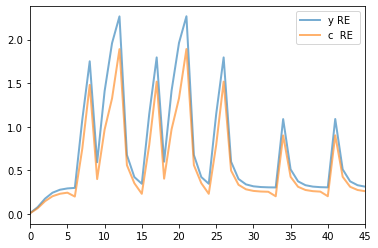

In [66]:

fig, ax = plt.subplots()
ax.plot(y_RE, lw=2, alpha=0.6,
label='y RE')
ax.plot(c_RE , lw=2, alpha=0.6,
label='c  RE ')
ax.legend()
ax.set_xlim(0, 45)
plt.savefig('C_Y_RE.pdf')


Comparison of the models 


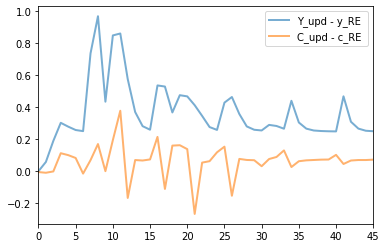

In [67]:
fig, ax = plt.subplots()
ax.plot(y_upd - y_RE, lw=2, alpha=0.6,
label='Y_upd - y_RE')
ax.plot(c_upd - c_RE , lw=2, alpha=0.6,
label='C_upd - c_RE ')
ax.legend()
ax.set_xlim(0, 45)
#plt.show()
plt.savefig('plotdiff.pdf')

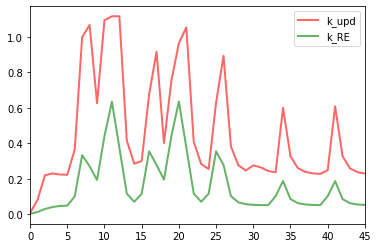

In [68]:
fig, ax = plt.subplots()
ax.plot(y_upd - c_upd,  color='r', lw=2,alpha=0.6, label='k_upd')
ax.plot(y_RE - c_RE, color = 'g', lw=2,alpha=0.6, label='k_RE')
ax.legend()
ax.set_xlim(0, 45)
plt.savefig('plot_k.pdf')

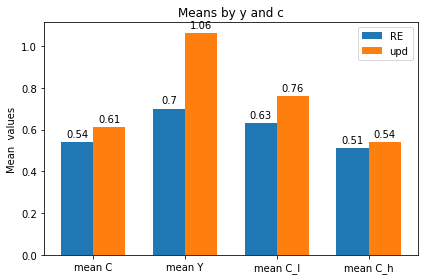

In [70]:

y_one = y_RE
c_one = c_RE
y_all = y_upd
c_all = c_upd

labels = ['mean C', 'mean Y', 'mean C_l','mean C_h']
means_one = [round(np.mean(c_one),2), round(np.mean(y_one),2),round(np.mean(c_one[X[0:50]=='h']),2), round(np.mean(c_one[X[0:50]=='l']),2)]
means_all = [round(np.mean(c_all),2), round(np.mean(y_all),2),round(np.mean(c_all[X[0:50]=='h']),2), round(np.mean(c_all[X[0:50]=='l']),2)]

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, means_one, width, label='RE')
rects2 = ax.bar(x + width/2, means_all, width, label='upd')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Mean  values')
ax.set_title('Means by y and c')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()


def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')


autolabel(rects1)
autolabel(rects2)

fig.tight_layout()

plt.savefig('means.pdf')

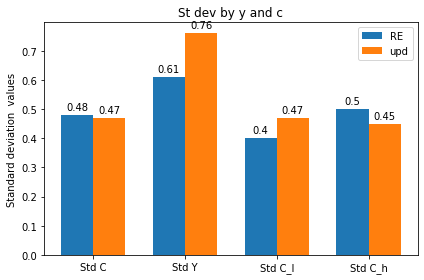

In [73]:
labels = ['Std C', 'Std Y', 'Std C_l','Std C_h']
y= y_one
means_one = [round(np.std(c_one),2), round(np.std(y),2),round(np.std(c_one[X[0:50]=='h']),2), round(np.std(c_one[X[0:50]=='l']),2)]
means_all = [round(np.std(c_all),2), round(np.std(y_all),2),round(np.std(c_all[X[0:50]=='h']),2), round(np.std(c_all[X[0:50]=='l']),2)]
x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, means_one, width, label='RE')
rects2 = ax.bar(x + width/2, means_all, width, label='upd')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Standard deviation  values')
ax.set_title('St dev by y and c')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()


def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')


autolabel(rects1)
autolabel(rects2)

fig.tight_layout()


plt.savefig('stdev.pdf')

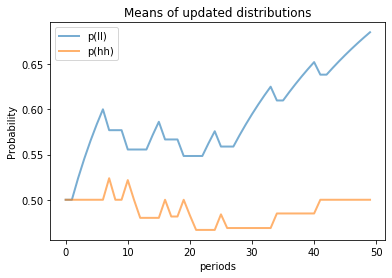

In [152]:
def calculatePupdated2(nii, nij):
    p =  np.empty(n, dtype = float)
    for i in range(len(p)):
        p[i] = beta.stats(nii[i],nij[i] , moments='m') 
    return p


p_upd2 = calculatePupdated2(nu00,nu01) 
q_upd2 = calculatePupdated2(nu01,nu11)



fig, ax = plt.subplots()
ax.plot(p_upd2, lw=2,alpha=0.6, label='p(ll)') 
label='Consumption upd '
ax.plot(q_upd2 ,lw=2,alpha=0.6, label='p(hh)')
ax.set_ylabel('Probability')
ax.set_xlabel('periods')
plt.title('Means of updated distributions')
#ax.set_xlim(0, 45)
ax.legend()

plt.savefig('plot0.pdf')

Case 3 :introduce the costs of upd :
- each iteration - compare two scenarious u_upd Vs u_no_upd
- cost: u(c_t - \phi ) +V(...)



In [124]:
# below is the weird possible way - just insert u(0.97*c)
@jitclass(opt_growth_data)
class OptimalGrowthModel_ϕ:
    def __init__ (self,
                  nuii  , # nu are values for beta function posterior 
                  nuij,
                  α = 0.4, #parameter of production function k^α
                  b = 0.96,
                  #ϕ = 0.07, # proportional cost
                  grid_max=n/2,
                  grid_size=n,
                  shock_size=n,  # by shock I mean the draw from the distribution of the probabbilities (Beta) 
                  seed=1234):   # that will be actually chosen by the agent as the posterior to act upon 
        #self.α, self.b, self.ϕ, self.nuii, self.nuij = α, b, ϕ , nuii, nuij
        self.α, self.b, self.nuii, self.nuij = α, b, nuii, nuij
                # Set up grid
        self.grid = np.linspace(1e-5, grid_max, grid_size)
                # Store shocks (with a seed, so results are reproducible)
        np.random.seed(seed)
        self.shocks =   (np.random.beta(nuii,nuij,shock_size))*((np.exp(1)-1)+1)
            #np.exp(1)*p +(1-p)np.exp(0)=p(np.exp(1)-1)+1 
            
    def f(self,k):
        return k**self.α
            
    def u(self, c):
        return np.log(c)
            
    def objective(self, c, y, v_array):
        """
         Right hand side of the Bellman equation.
        """
        u, f, b, shocks = self.u, self.f, self.b, self.shocks
        v = lambda x: interp(self.grid, v_array, x)
        return u(c-0.2*y) + b * np.mean(v(f(y - c) * shocks)) # with one-period ls cost
        
        

In [125]:
def simulate_Φ(y0,ts_length, Verbose):
    '''
    Compute a time series given consumption policy σ.
    '''
    n00 = np.ones(ts_length)*10 # these are variables to keep track of actual probablities used while choosing
                                # note :unlike nu.. n - are the probabilities used to predict current variables
    n01 = np.ones(ts_length)*10
    n10 = np.ones(ts_length)*10
    n11 = np.ones(ts_length)*10
    
    c = np.empty(ts_length)
    y = np.empty(ts_length)
    ξ = ( X == 'h')
    y[0] = y0
    n00[0] = nu00[0]
    n01[0] = nu01[0]
    n11[0] = nu11[0]
    n10[0] = nu10[0]
    for t in range(ts_length-1):
        if ξ[t] == 0 :
            #no upd case
            og = OptimalGrowthModel(nuii = n00[t],nuij = n01[t])#for prediction to the next period use the last used p             v_solution = solve_model(og,verbose= Verbose)
            v_solution = solve_model(og,verbose= Verbose)
            v_greedy = get_greedy(og, v_solution)
            σ_func = lambda x: interp(og.grid, v_greedy, x)
            
            # upd case
            og_u = OptimalGrowthModel_ϕ(nuii = nu00[t+1],nuij = nu01[t+1])
            v_solution_u = solve_model(og_u,verbose= Verbose)
            v_greedy_u = get_greedy(og_u, v_solution_u)
            σ_func_u = lambda x: interp(og_u.grid, v_greedy_u, x)   
            
            if σ_func(y[t]) > σ_func_u(y[t]): # no upd case
                c[t] = σ_func(y[t])
                y[t+1] = (y[t] - σ_func(y[t])  )**og.α * np.exp(ξ[t])
                n00[t+1] = n00[t] # record actually used probabilities
                n01[t+1] = n01[t] # record actually used probabilities
            else:
                c[t] = σ_func_u(y[t])
                y[t+1] = (y[t] - σ_func_u(y[t]) )**og.α * np.exp(ξ[t])
                n00[t+1] = nu00[t+1] # record actually used probabilities
                n01[t+1] = nu01[t+1] # record actually used probabilities
            
        else:
            #no upd case
            og = OptimalGrowthModel(nuii = n00[t],nuij = n01[t])#for prediction to the next period use the last used p             v_solution = solve_model(og,verbose= Verbose)
            v_solution = solve_model(og,verbose= Verbose)
            v_greedy = get_greedy(og, v_solution)
            σ_func = lambda x: interp(og.grid, v_greedy, x)
            
            # upd case
            og_u = OptimalGrowthModel_ϕ(nuii = nu11[t+1],nuij = nu11[t+1])
            v_solution_u = solve_model(og_u,verbose= Verbose)
            v_greedy_u = get_greedy(og_u, v_solution_u)
            σ_func_u = lambda x: interp(og_u.grid, v_greedy_u, x)   
            
            if σ_func(y[t]) > σ_func_u(y[t]): # no upd case
                c[t] = σ_func(y[t])
                y[t+1] = (y[t] - σ_func(y[t]))**og.α * np.exp(ξ[t])
                n10[t+1] = n10[t] # record actually used probabilities
                n11[t+1] = n11[t] # record actually used probabilities
            else:
                c[t] = σ_func_u(y[t])
                y[t+1] = (y[t] - σ_func_u(y[t]) )**og.α * np.exp(ξ[t])
                n10[t+1] = nu10[t+1] # record actually used probabilities
                n11[t+1] = nu11[t+1] # record actually used probabilities
    return y, c, n00, n01, n10, n11

In [126]:
y_ϕ, c_ϕ, n00,n01, n10, n11 =  simulate_Φ(y0 = 0.01 ,ts_length = 50, Verbose = False)

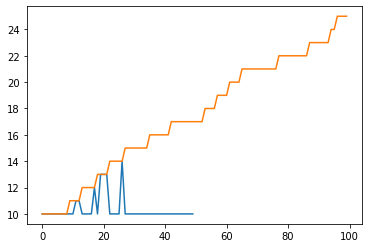

In [142]:

plt.plot(n10)
plt.plot(nu10)


(0, 45)

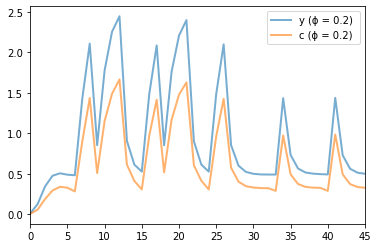

In [127]:
fig, ax = plt.subplots()
ax.plot(y_ϕ, lw=2, alpha=0.6,
label='y (ϕ = 0.2) ')
ax.plot(c_ϕ , lw=2, alpha=0.6,
label= 'c (ϕ = 0.2) ')
ax.legend()
ax.set_xlim(0, 45)
#plt.savefig('C_Y_costs.pdf')

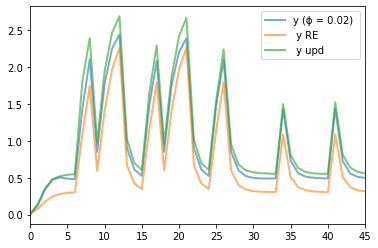

In [140]:
fig, ax = plt.subplots()
ax.plot(y_ϕ, lw=2, alpha=0.6,
label='y (ϕ = 0.02) ')
ax.plot(y_RE , lw=2, alpha=0.6,
label= ' y RE ')
ax.plot(y_upd , lw=2, alpha=0.6,
label= ' y upd ')
ax.legend()
ax.set_xlim(0, 45)
plt.savefig('Y_3cases.pdf')

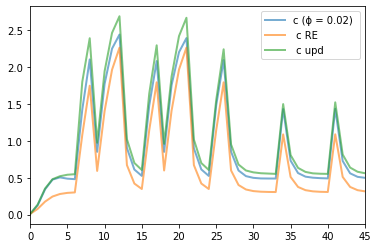

In [141]:
fig, ax = plt.subplots()
ax.plot(y_ϕ, lw=2, alpha=0.6,
label='c (ϕ = 0.02) ')
ax.plot(y_RE , lw=2, alpha=0.6,
label= ' c RE ')
ax.plot(y_upd , lw=2, alpha=0.6,
label= ' c upd ')
ax.legend()
ax.set_xlim(0, 45)
plt.savefig('C_3cases.pdf')

Try to write numba parallelized code to speed up

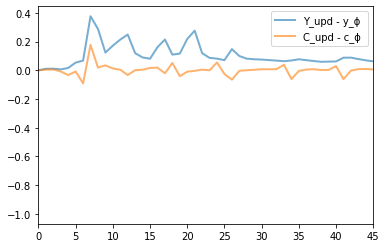

In [138]:
fig, ax = plt.subplots()
ax.plot(y_upd - y_ϕ, lw=2, alpha=0.6,
label='Y_upd - y_ϕ')
ax.plot(c_upd - c_ϕ , lw=2, alpha=0.6,
label='C_upd - c_ϕ ')
ax.legend()
ax.set_xlim(0, 45)
#plt.show()
plt.savefig('plotdiff_phi.pdf')

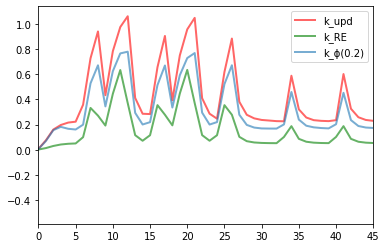

In [133]:
fig, ax = plt.subplots()
ax.plot(y_upd - c_upd,  color='r', lw=2,alpha=0.6, label='k_upd')
ax.plot(y_RE - c_RE, color = 'g', lw=2,alpha=0.6, label='k_RE')
ax.plot(y_ϕ - c_ϕ, lw=2,alpha=0.6, label='k_ϕ(0.2)')
ax.legend()
ax.set_xlim(0, 45)
plt.savefig('plot_k.pdf')

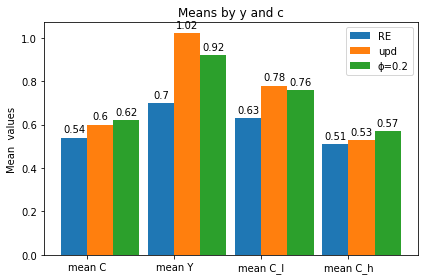

In [148]:

y_one = y_RE
c_one = c_RE
y_all = y_upd
c_all = c_upd

labels = ['mean C', 'mean Y', 'mean C_l','mean C_h']
means_one = [round(np.mean(c_one),2), round(np.mean(y_one),2),round(np.mean(c_one[X[0:50]=='h']),2), round(np.mean(c_one[X[0:50]=='l']),2)]
means_all = [round(np.mean(c_all),2), round(np.mean(y_all),2),round(np.mean(c_all[X[0:50]=='h']),2), round(np.mean(c_all[X[0:50]=='l']),2)]
means_ϕ = [round(np.mean(c_ϕ),2), round(np.mean(y_ϕ),2),round(np.mean(c_ϕ[X[0:50]=='h']),2), round(np.mean(c_ϕ[X[0:50]=='l']),2)]

x = np.arange(len(labels))  # the label locations
width = 0.3  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, means_one, width, label='RE')
rects2 = ax.bar(x + width/2, means_all, width, label='upd')
rects3 = ax.bar(x + 1.5*width, means_ϕ, width, label='ϕ=0.2')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Mean  values')
ax.set_title('Means by y and c')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()


def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')


autolabel(rects1)
autolabel(rects2)
autolabel(rects3)

fig.tight_layout()

plt.savefig('means_3cases.pdf')

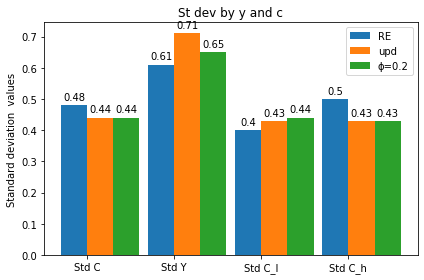

In [150]:
labels = ['Std C', 'Std Y', 'Std C_l','Std C_h']
y= y_one
means_one = [round(np.std(c_one),2), round(np.std(y),2),round(np.std(c_one[X[0:50]=='h']),2), round(np.std(c_one[X[0:50]=='l']),2)]
means_all = [round(np.std(c_all),2), round(np.std(y_all),2),round(np.std(c_all[X[0:50]=='h']),2), round(np.std(c_all[X[0:50]=='l']),2)]
means_ϕ = [round(np.std(c_ϕ),2), round(np.std(y_ϕ),2),round(np.std(c_ϕ[X[0:50]=='h']),2), round(np.std(c_ϕ[X[0:50]=='l']),2)]

x = np.arange(len(labels))  # the label locations
width = 0.3  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, means_one, width, label='RE')
rects2 = ax.bar(x + width/2, means_all, width, label='upd')
rects3 = ax.bar(x + 1.5*width, means_ϕ, width, label='ϕ=0.2')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Standard deviation  values')
ax.set_title('St dev by y and c')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()


def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')


autolabel(rects1)
autolabel(rects2)
autolabel(rects3)

fig.tight_layout()


plt.savefig('stdev_3cases.pdf')

In [199]:
# as tere were switching in the regimes - not all the probabilities were updated throughout the loop
#=> need to restore adequate evolution of probabilities. (firther -necessarily put it into the simulate.. function)

def restore_n (nii):
    #nii =n00
    renew = np.ones(len(nii))*10
    for i in range(len(nii)-1):    
        if nii[i+1] == 10:
            renew[i+1] = max(nii[0:(i+1)])
            
    return(renew)

ren00 = restore_n(n00)
ren01 = restore_n(n01)
ren10 = restore_n(n10)
ren11 = restore_n(n11)

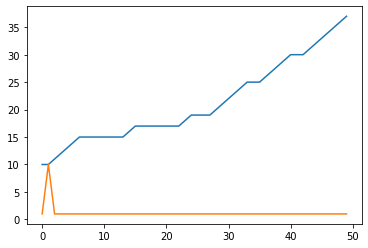

In [193]:
plt.plot(n00)
plt.plot(ren00)

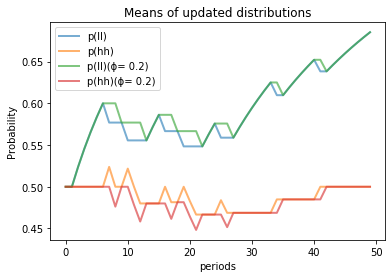

In [198]:



p_upd_ϕ = calculatePupdated2(ren00,ren01) 
q_upd_ϕ = calculatePupdated2(ren01,ren11)



fig, ax = plt.subplots()
ax.plot(p_upd2, lw=2,alpha=0.6, label='p(ll)') 
ax.plot(q_upd2 ,lw=2,alpha=0.6, label='p(hh)')
ax.plot(p_upd_ϕ, lw=2,alpha=0.6, label='p(ll)(ϕ= 0.2)') 
ax.plot(q_upd_ϕ ,lw=2,alpha=0.6, label='p(hh)(ϕ= 0.2)')
ax.set_ylabel('Probability')
ax.set_xlabel('periods')
plt.title('Means of updated distributions')
#ax.set_xlim(0, 45)
ax.legend()

#plt.savefig('plot0_phi.pdf')

In [190]:
# calculate the number of updatings

def calculate_upd (nii):
    sumii = 0
    for i in range(len(nii)-1):
        sumii += ((nii[i+1] - nii[i]) != 0)
    return sumii

print(calculate_upd(n00),
calculate_upd(n01),
calculate_upd(n10),
calculate_upd(n11))

27 7 4 7
